<a href="https://colab.research.google.com/github/mymggithub/Stock-Price-Prediction-Machine-Learning/blob/master/Spy_prediction_AI_with_range.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

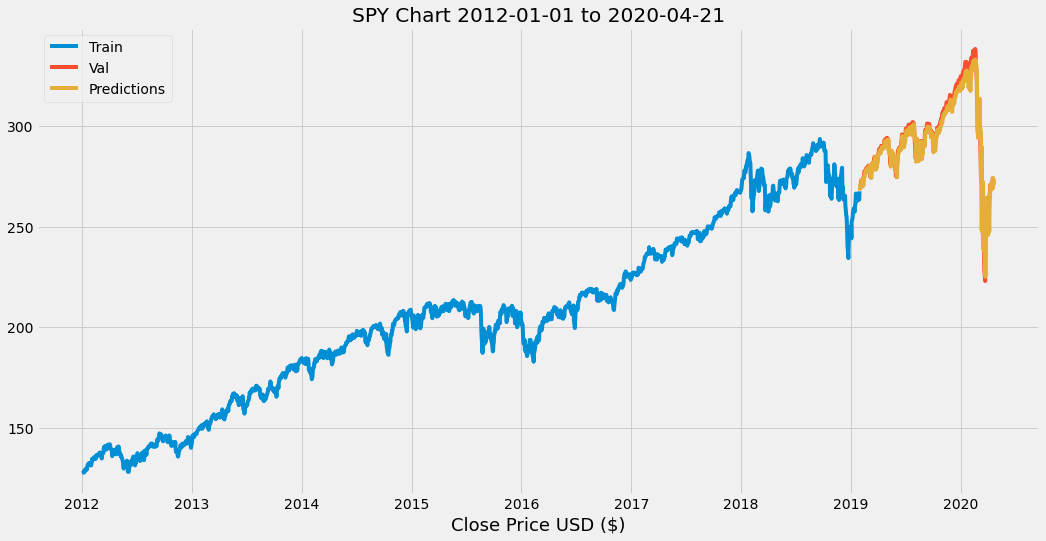

,Close,Predictions,Closed Net Change,Predictioned Net Change,Close vs Predictions
2020-03-24,243.149994,225.135239,20.199997,-5.039124,25.239120
2020-03-25,246.789993,246.315598,3.639999,21.180359,-17.540359
2020-03-26,261.200012,248.635284,14.410019,2.319687,12.090332
2020-03-27,253.419998,264.410248,-7.780014,15.774963,-23.554977
2020-03-30,261.649994,254.205765,8.229996,-10.204483,18.434479
2020-03-31,257.750000,263.756622,-3.899994,9.550858,-13.450851
2020-04-01,246.149994,257.813873,-11.600006,-5.942749,-5.657257
2020-04-02,251.830002,245.934387,5.680008,-11.879486,17.559494
2020-04-03,248.190002,252.480057,-3.639999,6.545670,-10.185669
2020-04-06,264.859985,247.775620,16.669983,-4.704437,21.374420


In [0]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
# from keras.models import Sequential
# from keras.layers import Dense,LSTM
from tensorflow.python.keras.layers import Dense,LSTM
from tensorflow.python.keras import Sequential
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
import datetime

# Google settings
import warnings
warnings.filterwarnings('ignore')

from google.colab import output, auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())
from gspread_dataframe import get_as_dataframe, set_with_dataframe

start_with = '2012-01-01'
future_days = 15
pred_last_close = 0.0
ticker = "SPY"
epoch = 10
load_file = ''



next_date = today = datetime.date.today()
next_date_str = today.strftime("%Y-%m-%d %H:%M:%S")
df = web.DataReader(ticker, data_source='yahoo', start=start_with,end=today.strftime("%Y-%m-%d"))

if load_file:
  t = pd.to_datetime(str(df.iloc[-1:].index.values[0]))
  timestring = t.strftime("%Y-%m-%d %-H:%M:%S")
  worksheet = gc.open(load_file).sheet1
  tmp_df = get_as_dataframe(worksheet, parse_dates=True, usecols=[0,1]) #,2,3,4,5
  tmp_df = tmp_df.dropna()
  tmp_df = tmp_df.rename(columns={tmp_df.columns[0]: 'Date'})
  tmp_df = tmp_df.iloc[tmp_df[tmp_df['Date']==timestring].index.values[0]+1:]
  next_date = today = datetime.datetime.strptime(tmp_df["Date"].iloc[-1],"%Y-%m-%d %H:%M:%S")
  tmp_df['Date']= pd.to_datetime(tmp_df['Date']) 
  tmp_df2 = tmp_df.set_index("Date")
  df = pd.concat([df, tmp_df2])

for days_i in range(future_days+1):
  if future_days==0:
    break
  start_time = pd.Timestamp.now()
  if days_i > 0:
    tmp = df
    next_date = today + datetime.timedelta(days=days_i)
    next_date_str = next_date.strftime("%Y-%m-%d %H:%M:%S")
    df = pd.concat([df, pd.DataFrame([pd.Series({"Close":pred_last_close})], index = [datetime.datetime.strptime(next_date_str,"%Y-%m-%d %H:%M:%S")])])
  data = df.filter(['Close'])
  dataset = data.values
  training_data_len = math.ceil( len(dataset) * .85 )
  scaler = MinMaxScaler(feature_range=(0,1))
  scaled_data = scaler.fit_transform(dataset)
  train_data = scaled_data[0:training_data_len, :]
  x_train = []
  y_train = []
  for i in range(60 ,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])
  x_train, y_train = np.array(x_train), np.array(y_train)
  x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
  print()
  print ('Currently running {}: {}/{}'.format(next_date.strftime("%Y-%m-%d"),days_i,future_days))
  model = Sequential()
  model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
  model.add(LSTM(50, return_sequences=False))
  model.add(Dense(25))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mean_squared_error')
  verbose = 1
  if epoch>1:
    verbose = 0
  model.fit(x_train, y_train, batch_size=1, epochs=epoch, verbose=verbose)
  test_data = scaled_data[training_data_len - 60: , :]
  x_test = []
  y_test = dataset[training_data_len:, :]
  for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
  x_test = np.array(x_test)
  x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
  predictions = model.predict(x_test)
  predictions = scaler.inverse_transform(predictions)
  rsme = np.sqrt( np.mean( predictions - y_test)**2 )
  print ('rsme error: {:f}'.format(rsme))
  train = data[:training_data_len]
  valid = data[training_data_len:]
  valid["Predictions"] = predictions
  df['Close Yesterday'] = df['Close'].shift()
  valid["Closed Net Change"] = df['Close']-df['Close Yesterday']
  df['Predictions Yesterday'] = valid['Predictions'].shift()
  valid["Predictioned Net Change"] = valid['Predictions']-df['Predictions Yesterday']
  valid["Close vs Predictions"] = valid["Closed Net Change"] - valid["Predictioned Net Change"]
  new_df = data
  last_60_days = new_df[-60:].values
  last_60_days_scaled = scaler.transform(last_60_days)
  X_test = []
  X_test.append(last_60_days_scaled)
  X_test = np.array(X_test)
  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
  pred_price = model.predict(X_test)
  pred_price = scaler.inverse_transform(pred_price)
  pred_last_close = pred_price[0][0]
  print ('{} Prediction: {:f}'.format(next_date.strftime("%Y-%m-%d"),pred_last_close))
  print('{} [{}] elapse time: {}'.format(next_date.strftime("%Y-%m-%d"),days_i,pd.Timestamp.now()-start_time))
  try:
    if days_i==0:
      sh = gc.create(ticker)
      worksheet = gc.open(ticker).sheet1
    set_with_dataframe(worksheet, valid, include_index=True)
  except:
    print("Might need to re-auth")
    auth.authenticate_user()
    gc = gspread.authorize(GoogleCredentials.get_application_default())
    worksheet = gc.open(ticker).sheet1

output.clear()

# if future_days==0:
#   valid["Predictions"] = valid["Close"]

plt.figure(figsize=(16,8))
plt.title(ticker+" Chart "+start_with+" to "+next_date.strftime("%Y-%m-%d"))
plt.xlabel("Date", fontsize=18)
plt.xlabel("Close Price USD ($)", fontsize=18)
plt.plot(train["Close"])
plt.plot(valid[["Close", "Predictions"]])
plt.legend(["Train", "Val", "Predictions"], loc="upper left")
plt.show()
valid.tail(future_days+10)

In [0]:
valid.tail(25+10)

In [0]:
import pandas_datareader as web
import pandas as pd 
import datetime

from google.colab import output, auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())
from gspread_dataframe import get_as_dataframe, set_with_dataframe


next_date = today = datetime.date.today()
next_date_str = today.strftime("%Y-%m-%d %H:%M:%S")
df = web.DataReader("SPY", data_source='yahoo', start='2012-01-01',end=today.strftime("%Y-%m-%d"))
t= pd.to_datetime(str(df.iloc[-1:].index.values[0])) 
timestring = t.strftime("%Y-%m-%d %-H:%M:%S")

gc = gspread.authorize(GoogleCredentials.get_application_default())
worksheet = gc.open('SPY l10').sheet1
tmp_df = get_as_dataframe(worksheet, parse_dates=True, usecols=[0,1]) #,2,3,4,5
tmp_df = tmp_df.dropna()
tmp_df = tmp_df.rename(columns={tmp_df.columns[0]: 'Date'})

# tmp_df = tmp_df.iloc[tmp_df[tmp_df['Date']=='2020-04-08 0:00:00'].index.values[0]-1:]
# 2020-04-03 00:00:00
# 2020-04-03 0:00:00
tmp_df2 = tmp_df.set_index("Date")
# tmp_df2 = pd.concat([tmp_df, tmp_df])
# tmp_df["Date"].iloc[-1]
# tmp_df.tail(10)

tmp_df = tmp_df.iloc[tmp_df[tmp_df['Date']==timestring].index.values[0]+1:]
tmp_df2 = tmp_df.set_index("Date")
pd.concat([df, tmp_df2]).tail(10)

In [0]:
import pandas_datareader as web
import pandas as pd 
import datetime
next_date = today = datetime.date.today()
next_date_str = today.strftime("%Y-%m-%d %H:%M:%S")
df = web.DataReader("SPY", data_source='yahoo', start='2012-01-01',end=today.strftime("%Y-%m-%d"))
t= pd.to_datetime(str(df.iloc[-1:].index.values[0])) 
timestring = t.strftime('%Y.%m.%d')
timestring